## Calculate local available potential energy
**22 March 2022 by MiniUFO**

---
[TOC]

---
### 1. Introduction
Available potential energy (APE) is a useful quantity in diagnosing energetics of geofluid.  It is defined as the domain integral of the potential energy (PE) difference between actual state and a minimum PE state (or reference state):
$$
\begin{align}
E_a = \int e_a dV = g\int \left(\rho' z\right) dV = g\int \left(\rho - \rho_R\right) z dV \tag{1}
\end{align}
$$
where $\rho$ is the density of a instantaneous state， $\rho_R$ the density of stably-stratified (vertically-sorted) motionless state (or reference state), and $e_a$ the APE density.  It is easy to define APE density $e_p$ as:
$$
\begin{align}
e_a = \left(\rho - \rho_R\right)g z \tag{2}
\end{align}
$$
However, this is different from the eddy kinetic energy that is always positive.  Large cancellation between positive and negative $e_p$ will be observed in the calculation, which is not physically useful, as we expect energy should be positive definite.


---


### 2. Theoretical guide
Commonly used definition of APE density is:
$$
\begin{align}
e_a = -\frac{g}{2}\frac{\rho'^2}{\partial\rho/\partial z} \tag{3}
\end{align}
$$
This is a small-amplitude approximation or the QG version.  In the finite-amplitude case, one need the most accurate definition by [Holliday and McIntyre (1981)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/on-potential-energy-density-in-an-incompressible-stratified-fluid/75CBC2DE788C9D22EA211BE91C4F2167):
$$
\begin{align}
e_a &= \int_{z_r(\rho)}^z g\left[\rho-\rho_r\left(z'\right)\right] dz' \tag{4}\\
&= \int_0^\eta g\left[\rho-\rho_r\left(z+z'\right)\right] dz' \tag{4'}
\end{align}
$$
If we compare Eq. (4') with local wave activity proposed by [Huang and Nakamura](https://journals.ametsoc.org/view/journals/atsc/73/1/jas-d-15-0194.1.xml), we could find that they are mathematically similar [see also [Roullet and Klein (2009)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/available-potential-energy-diagnosis-in-a-direct-numerical-simulation-of-rotating-stratified-turbulence/906E71577A230B90B48D8CEB442EE873)].  The difference is their units and that local wave activity density is defined in the hoziontal plane while local APE density is in the vertical plane.

Based on this fact, the local APE density calculation is exactly the same as local wave activity density.  There could be a sign difference if one call `cal_local_wave_activity()` to calculate local APE density.  Since both of them are positive definite, just multiplying `-1` would give the right answer.

---

### 3. Calculation procedure
#### 3.1 Load data
Here for demonstrating purpose, we use a sample data of [internal wave breaking over topography simulated using MITgcm](https://github.com/miniufo/InternalWaveBreaking).

First, we read in the data and calculate the conservatively-sorted reference state:

In [1]:
import xarray as xr
import numpy as np
import sys
sys.path.append('../../')
from xgcm import Grid
from xcontour.xcontour import Contour2D

##################################  load data  #######################################
ds = xr.open_dataset('../Data/internalwave.nc')

# add metrics for xgcm.Grid
grid = Grid(ds, metrics = {
        ('X',)    : ['dxG', 'dxF', 'dxC', 'dxV'], # X distances
        ('Z',)    : ['drW', 'drS', 'drC', 'drF', 'drG'], # Z distances
        ('X', 'Z'): ['yA']}) # Areas in X-Z plane

# get potential temperature and maskout due to topography
T = ds.THETA.where(ds.maskC)

# calculate buoyancy using linear EOS
alpha = 2E-4
T0 = 20
g = 9.81
b = (alpha * (T - T0) * g).rename('b')

###########################  calculate sorted state  #################################
# Initialize equally-spaced contours from minimum value to maximum
# value (within lat/lon dims).  Here will implicitly loop over each isentropic level
%matplotlib inline
N  = 121           # increase the contour number may get non-monotonic A(q) relation
increase = False   # Y-index increases with latitude (sometimes not)
lt = True          # northward of PV contours (larger than) is inside the contour
                   # change this should not change the result of Keff, but may alter
                   # the values at boundaries
dtype = np.float32 # use float32 to save memory
undef = -9.99e8    # for maskout topography if present

# initialize a Contour2D analysis class using grid and tracer
analysis = Contour2D(grid, b,
                     dims={'X':'XC','Z':'Z'},
                     dimEq={'Z':'Z'},
                     increase=increase,
                     lt=lt)
# evenly-spaced contours
ctr = analysis.cal_contours(N)

# Mask for A(q) relation table.
# This can be done analytically in simple case, but we choose to do it
# numerically in case there are undefined values inside the domain.
mask = ds.maskC

# calculate related quantities for 
table = analysis.cal_area_eqCoord_table(mask) # A(Yeq) table
area  = analysis.cal_integral_within_contours(ctr).rename('intArea')
ZEq   = table.lookup_coordinates(area).rename('ZEq')

#####################  interpolat to equivalent latitudes  ###########################
# combined the results
ds_contour = xr.merge([ctr, area, ZEq])

# interpolate from contour space to original latitudes
preZs = ds.Z.astype(dtype)
# results in latEq space
ds_ZEq = analysis.interp_to_dataset(preZs, ZEq, ds_contour)

case 1: decrease & lt


When we get the sorted profile of buoyancy, we can calculate the local APE density.

In [2]:
#%% calculate local finite-amplitude wave activity
lape, contours, masks = analysis.cal_local_APE(b,          # buoyancy
                                            ds_ZEq.b,      # the sorted buoyancy
                                            mask_idx=[8,28,51,81])   # select these mask to see the area of LAPE

Now we can take a look at the results.

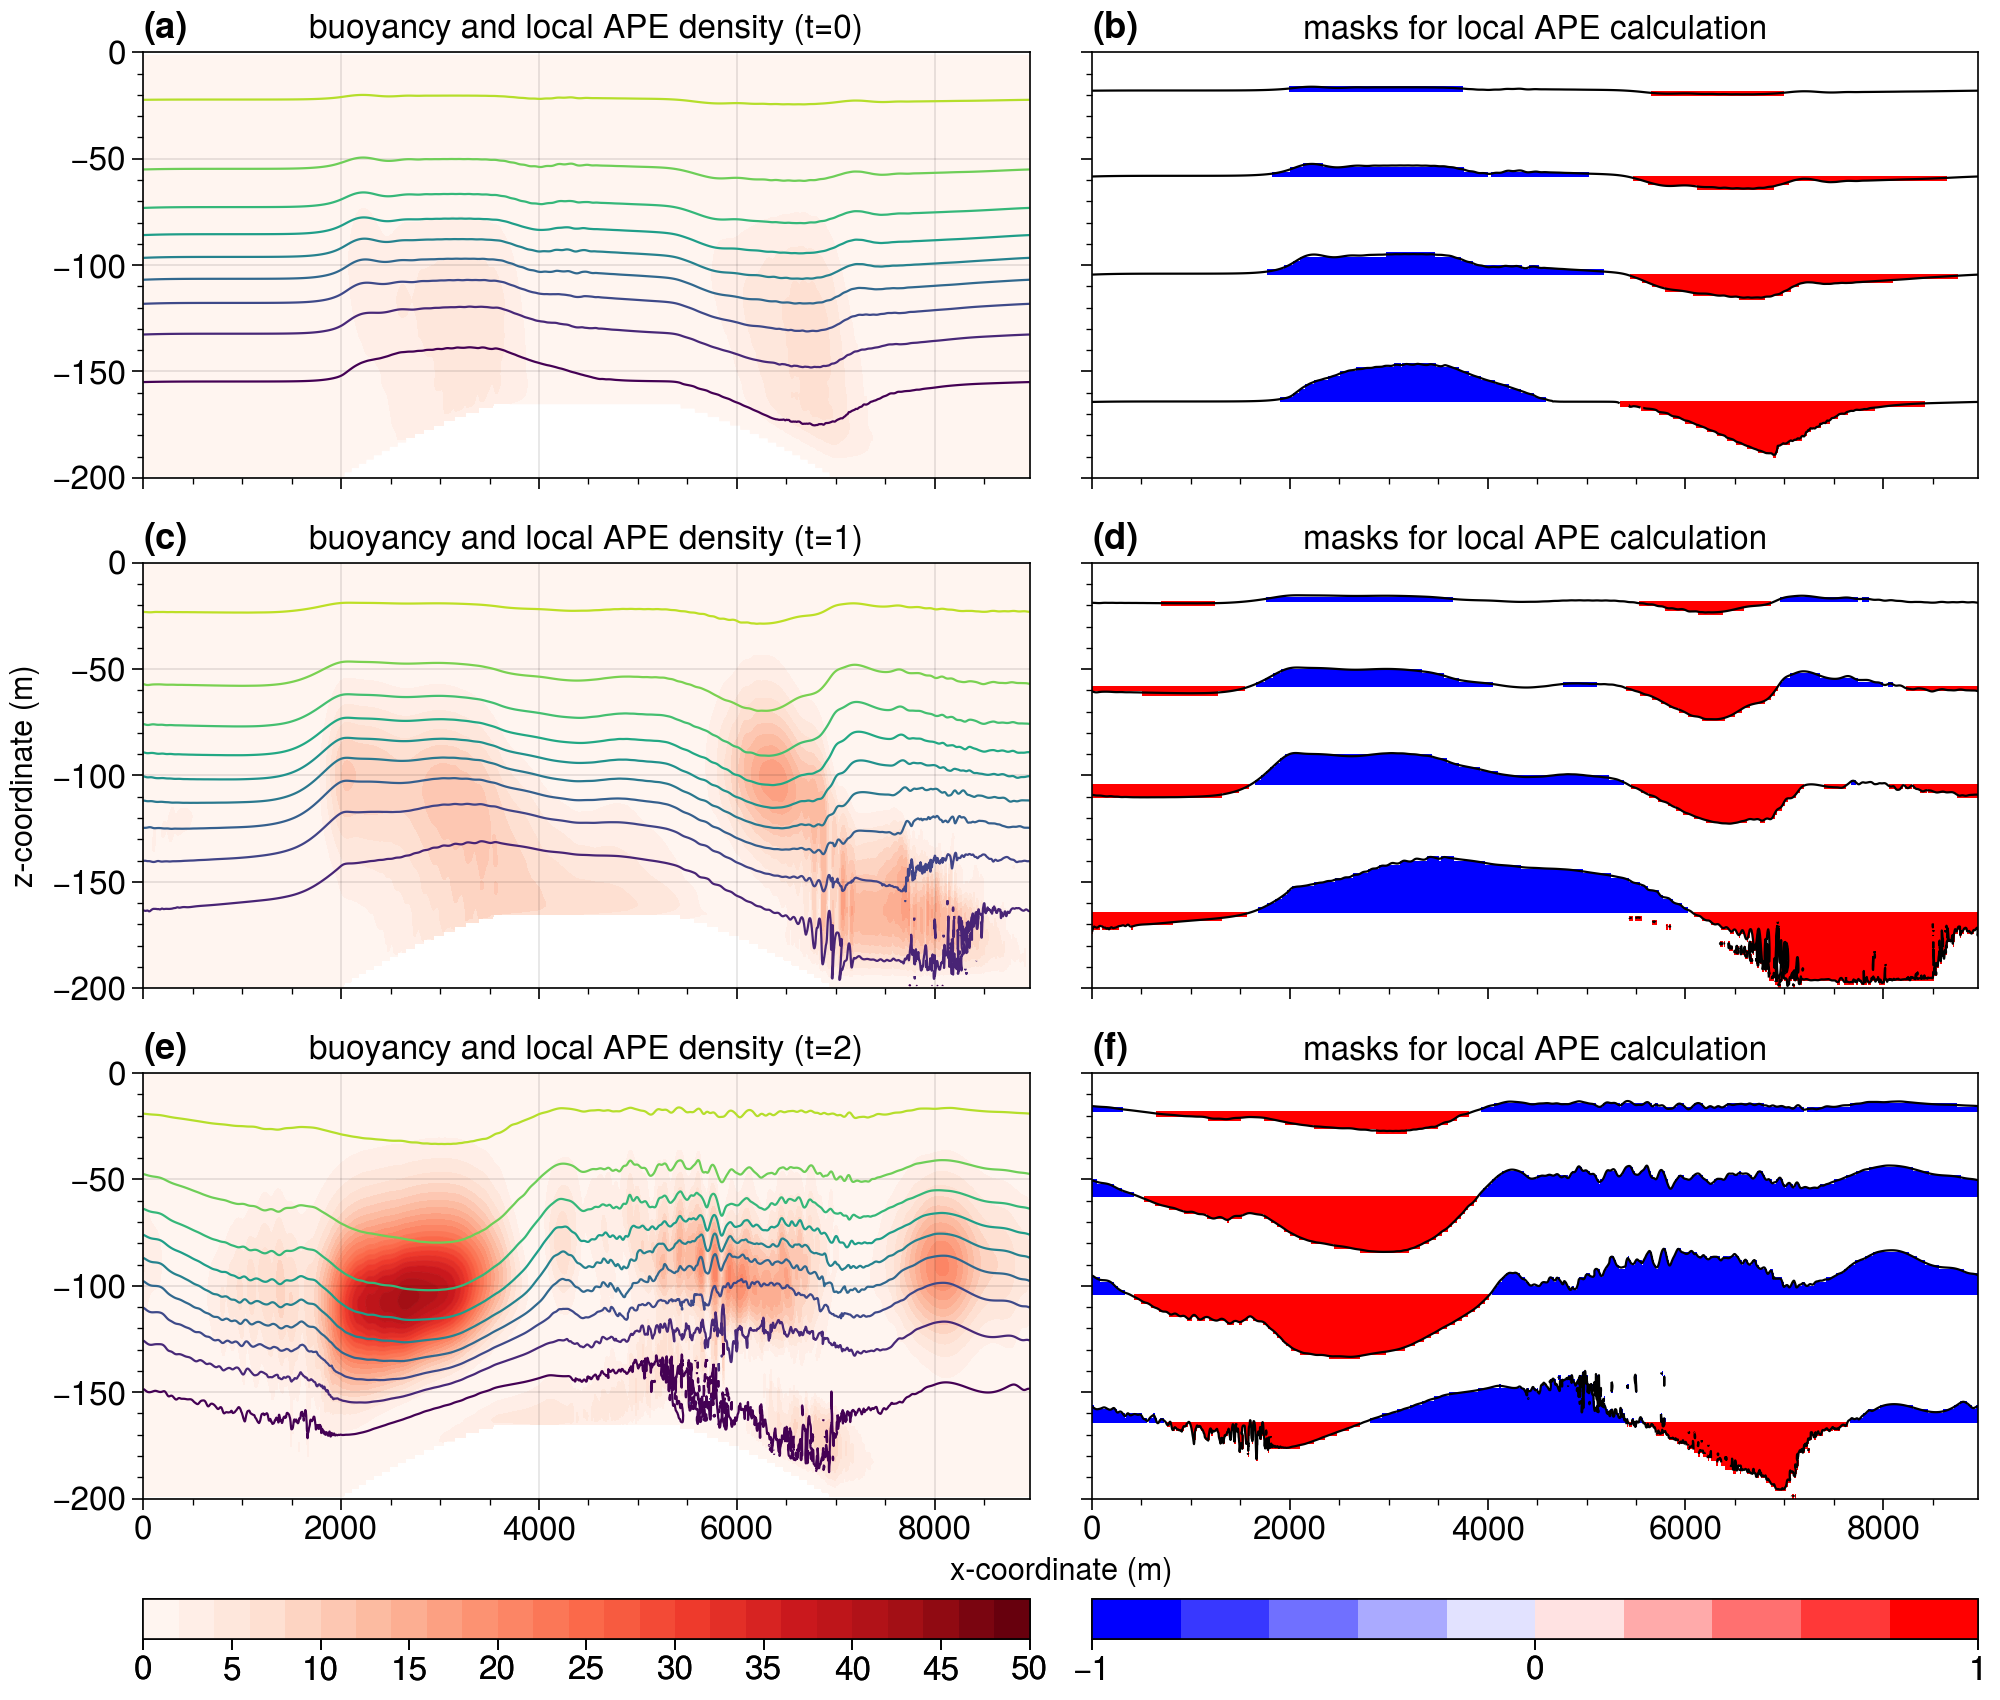

In [5]:
import proplot as pplt

fig, axes = pplt.subplots(nrows=3, ncols=2, figsize=(10, 8.5), sharex=3, sharey=3)

fontsize = 12

def plot_time(tidx, add_colorbar=False):
    ax = axes[tidx, 0]
    m1=ax.contourf(-lape.where(mask)[tidx]*1e4, levels=np.linspace(0,50,26), cmap='reds') # minus sign to ensure positive definite
    ax.contour(b.where(mask)[tidx], levels=11, cmap='viridis', lw=0.8)
    if add_colorbar:
        ax.colorbar(m1, loc='b', ticks=5, label='')
    ax.set_title('buoyancy and local APE density (t={})'.format(tidx), fontsize=fontsize)
    ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-1)
    ax.set_ylabel('z-coordinate (m)', fontsize=fontsize-1)
    ax.set_xticks([0, 2000, 4000, 6000, 8000])
    ax.set_yticks([-200, -150, -100, -50, 0])
    ax.set_ylim([-200, 0])
    
    ax = axes[tidx, 1]
    msk = sum(masks)
    lev = xr.concat(contours, 'Z').isel(time=tidx).values
    m1=ax.pcolormesh(msk.where(msk!=0)[tidx], cmap='bwr')
    ax.contour(b.where(mask)[tidx], levels=lev, lw=0.8, color='k')
    if add_colorbar:
        ax.colorbar(m1, loc='b', ticks=1, label='')
    ax.set_title('masks for local APE calculation', fontsize=fontsize)
    ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-1)
    ax.set_ylabel('z-coordinate (m)', fontsize=fontsize-1)
    ax.set_xticks([0, 2000, 4000, 6000, 8000])
    ax.set_yticks([-200, -150, -100, -50, 0])
    ax.set_ylim([-200, 0])

plot_time(0)
plot_time(1)
plot_time(2, True)

axes.format(abc='(a)')

It is clear that local APE density is all positive, and large local APE centers are located at regions where contours greatly deviate from its equilibrant places.  However, it is shown that these large centers are not corresponding to internal-wave breaking regions where contours are greatly stretched and folded (zigzag).  Therefore, large local APE density is not a region of significant irreversible mixing.

#### References
1. Holliday, D., and M. E. McIntyre, 1981: [On potential energy density in an incompressible, stratified fluid](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/on-potential-energy-density-in-an-incompressible-stratified-fluid/75CBC2DE788C9D22EA211BE91C4F2167). *J. Fluid Mech.*, **107**, 221-225.
2. Huang, C. S. Y., and N. Nakamura, 2016: [Local finite-amplitude wave activity as a diagnostic of anomalous weather events](https://journals.ametsoc.org/view/journals/atsc/73/1/jas-d-15-0194.1.xml). *J. Atmos. Sci.*, **73**, 211-229.
3. Roullet, G., and P. Klein, 2009: [Available potential energy diagnosis in a direct numerical simulation of rotating stratified turbulence](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/available-potential-energy-diagnosis-in-a-direct-numerical-simulation-of-rotating-stratified-turbulence/906E71577A230B90B48D8CEB442EE873). *J. Fluid Mech.*, **624**, 45-55.